In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image  

In [6]:
# uploading dataset
df = pd.read_csv("heloc_dataset_v1(exc empty rows.).csv_pre(-1,asis).csv")

In [7]:
# dividing dataset in X and Y
X = df.iloc[:,:23]
Y = df.iloc[:,-1]
label_map = {"Good": 0, "Bad": 1}

# Convert labels
Y = pd.Series([label_map[label] for label in Y])

In [8]:
# splitting X and Y randomly in test and train subsets with 80% of obersvations in train and 20% in test 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [9]:
# creating trainint dataset by combining X and Y 
df_train = pd.concat([pd.DataFrame(X_train), pd.Series(Y_train, name='RiskPerformance')], axis=1)

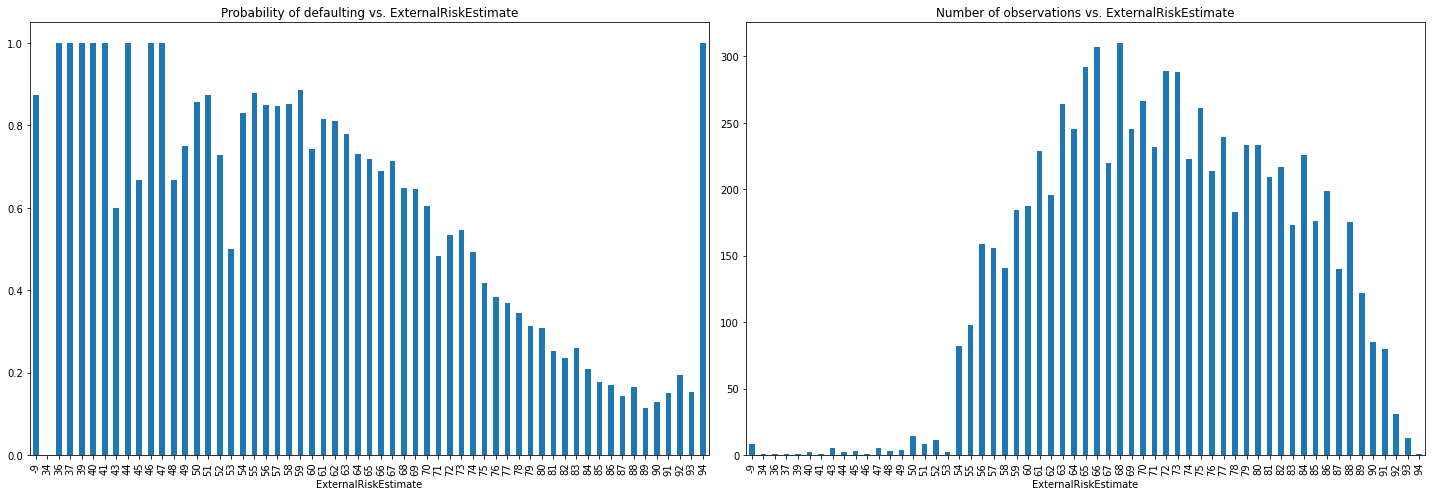

In [10]:
# grouping by exteranl risk estimate and calculating means and counts to analyze distribution in relation to probability of defualting

means = df_train.groupby('ExternalRiskEstimate')['RiskPerformance'].mean()
counts = df_train.groupby('ExternalRiskEstimate')['RiskPerformance'].count()

# plotting it
fig, axes = plt.subplots(1,2, figsize=(20,7))
means.plot.bar(ax=axes[0], title='Probability of defaulting vs. ExternalRiskEstimate')
counts.plot.bar(ax=axes[1], title='Number of observations vs. ExternalRiskEstimate')
plt.tight_layout()
plt.savefig('graph 3.png')

Risk monotoincally decreasing with increasing extenalriskestimate, which makes sense if we look at Data dictionary. Most of obersvations are between 54 and 91, outside of which there is noise as we lack observations. Among this range, we see how the trend is stronger on the left figure. Finally, we see that -9 (which are missing values) are defaulted in most cases.

In [11]:
# excluding missing values of externalriskestimate from train and test X datasets 
valid_indices_train = X_train.loc[:, 'ExternalRiskEstimate'] != -9
valid_indices_test = X_test.loc[:, 'ExternalRiskEstimate'] != -9

# Filter out observations where ExternalRiskEstimate is not missing
X_train = X_train[valid_indices_train]
Y_train = Y_train[valid_indices_train]

X_test = X_test[valid_indices_test]
Y_test = Y_test[valid_indices_test]

In [12]:
# create a data frame that indicates how many of each of the three values used to indicate missing values are present in each column (-7,-8,-9)
df_count_missing = pd.concat([(X_train==-7).sum(), (X_train==-8).sum(), (X_train==-9).sum()], axis=1)
df_count_missing.columns = [-7,-8,-9]
df_count_missing

,-7,-8,-9
ExternalRiskEstimate,0,0,0
MSinceOldestTradeOpen,0,199,0
MSinceMostRecentTradeOpen,0,0,0
AverageMInFile,0,0,0
NumSatisfactoryTrades,0,0,0
NumTrades60Ever2DerogPubRec,0,0,0
NumTrades90Ever2DerogPubRec,0,0,0
PercentTradesNeverDelq,0,0,0
MSinceMostRecentDelq,3727,130,0
MaxDelq2PublicRecLast12M,0,0,0


As we excluded observations that had -9 in externalriskestimate (only variable with -9s), we can now see hoe -8s and -7s are distributed across different columns. 

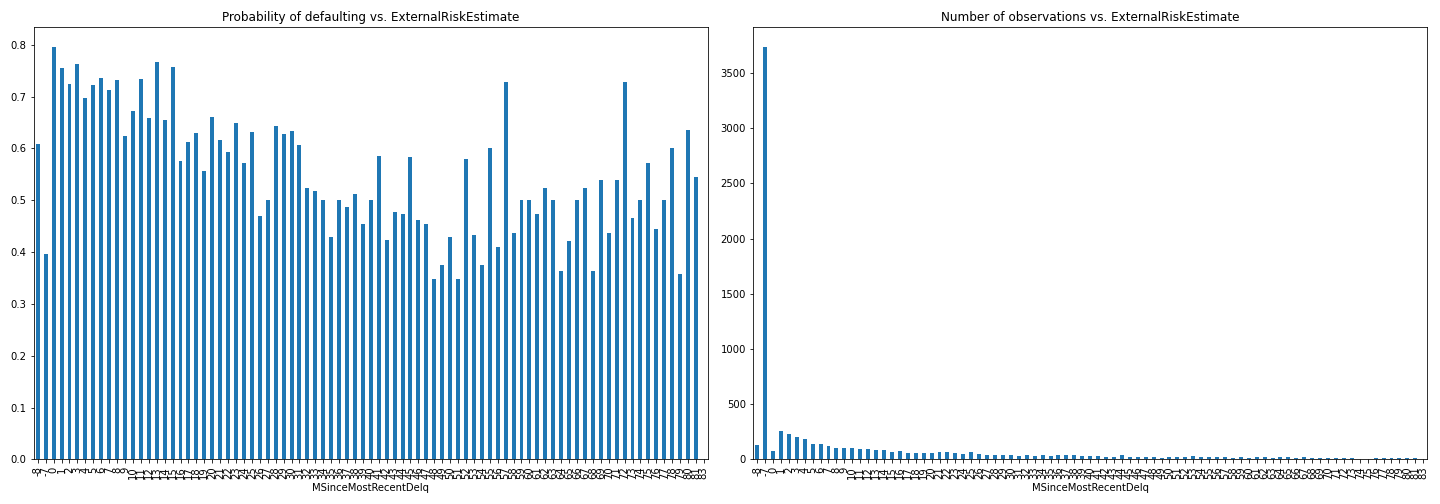

In [14]:
# plotting to see how mssincemostrecentdelq moves in relation to probability of defaulting. mssincemostrecentdelq is specifically taken
# to analysis as it is the variable with highest number of missing values
Image(filename='Risk vs MSinceMostRecentDelq.png')

Risk seems to be generally decreasing as MSsincemostrecentdelq increases. Moreover, it seems that number of missing values decreases as MSincemostrecentdelq increases.

Creating a Pipeline

In [18]:
# importing
from sklearn.impute import MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

In [19]:
from sklearn.pipeline import Pipeline

do_nothing_imputer = ColumnTransformer([("Imputer -7 to mean", SimpleImputer(missing_values=-7, strategy='mean'), [])], remainder='passthrough')

feature_expansion = FeatureUnion([("do nothing", do_nothing_imputer),
                                  ("add features for -7", MissingIndicator(missing_values=-7, features='missing-only')),
                                  ("add features for -8", MissingIndicator(missing_values=-8, features='missing-only'))])
 
pipeline = Pipeline([("expand features", feature_expansion), 
                 ("replace -7 with -8", SimpleImputer(missing_values=-7, strategy='constant', fill_value=-8)),
                 ("replace -8 with mean", SimpleImputer(missing_values=-8, strategy='mean'))])

arr_X_train_t = pipeline.fit_transform(X_train)

In [20]:
# printing shapes
print('The dimensions of X_train:',X_train.shape)
print('The dimensions of the transformed X_train:',arr_X_train_t.shape)

The dimensions of X_train: (7888, 23)
The dimensions of the transformed X_train: (7888, 34)


In [21]:
# appling imputers to training set and creating new columns
minus_7_indicator_transformer = MissingIndicator(missing_values=-7, features='missing-only').fit(X_train)
minus_8_indicator_transformer = MissingIndicator(missing_values=-8, features='missing-only').fit(X_train)
col_names_minus_7 = X_train.columns.values[minus_7_indicator_transformer.features_].tolist() 
col_names_minus_7 = list(map(lambda s:str(s)+'=-7',col_names_minus_7)) 
col_names_minus_8 = X_train.columns.values[minus_8_indicator_transformer.features_].tolist() 
col_names_minus_8 = list(map(lambda s:str(s)+'=-8',col_names_minus_8))
column_names = X_train.columns.values.tolist() + col_names_minus_7 + col_names_minus_8

In [25]:
# creating X_train_t wiht all transformed columns and rows
X_train_t = pd.DataFrame(arr_X_train_t, columns=column_names)
X_train_t

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days=-7,MSinceOldestTradeOpen=-8,MSinceMostRecentDelq=-8,MSinceMostRecentInqexcl7days=-8,NetFractionRevolvingBurden=-8,NetFractionInstallBurden=-8,NumRevolvingTradesWBalance=-8,NumInstallTradesWBalance=-8,NumBank2NatlTradesWHighUtilization=-8,PercentTradesWBalance=-8
0,68.0,60.0,7.0,31.0,11.0,1.0,0.0,92.0,27.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.0,123.0,1.0,47.0,18.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,65.0,56.0,3.0,21.0,7.0,0.0,0.0,86.0,38.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,87.0,130.0,12.0,46.0,26.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,56.0,193.0,46.0,88.0,22.0,0.0,0.0,78.0,3.000000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,90.0,214.0,9.0,110.0,20.0,0.0,0.0,100.0,21.751675,7.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
7884,68.0,158.0,2.0,70.0,42.0,0.0,0.0,98.0,54.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7885,80.0,344.0,4.0,92.0,35.0,0.0,0.0,94.0,59.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7886,64.0,480.0,15.0,92.0,31.0,1.0,1.0,94.0,3.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
# doing the same with test data
arr_X_test_t = pipeline.transform(X_test)

X_test_t = pd.DataFrame(arr_X_test_t, columns=column_names)

In [27]:
# randomly splitting training data into training and validation data with proportion of 25% validation and 75% training
X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val = train_test_split(X_train_t, Y_train, test_size=0.25, random_state=1234)


In [28]:
# printing shapes
print('The shape of X:', X.shape)
print('The shape of X_test_t:', X_test_t.shape)
print('The shape of X_train_t:', X_train_t.shape)
print('The shapes of X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val:', X_train_t_tr.shape, X_train_t_val.shape, Y_train_t_tr.shape, Y_train_t_val.shape)

The shape of X: (9871, 23)
The shape of X_test_t: (1973, 34)
The shape of X_train_t: (7888, 34)
The shapes of X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val: (5916, 34) (1972, 34) (5916,) (1972,)


Linear Models

In [29]:
# importing lindear models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

In [30]:
# logistic regression
log_reg = LogisticRegression(max_iter=10000, random_state=0).fit(X_train_t_tr, Y_train_t_tr) # Logistic regression

In [31]:
# printing accuracies of logistic regressions on training and validation
print('Train accuracy')
print('Log. Reg. accuracy: %.3f'%log_reg.score(X_train_t_tr, Y_train_t_tr))

print('\nValidation accuracy')
print('Log. Reg. accuracy: %.3f'%log_reg.score(X_train_t_val, Y_train_t_val))

Train accuracy
Log. Reg. accuracy: 0.742

Validation accuracy
Log. Reg. accuracy: 0.731


In [32]:
# store the coefficients of logistic regression
log_reg_coefficients = log_reg.coef_[0]
log_reg_coefficients = np.append(log_reg_coefficients, log_reg.intercept_[0])

In [35]:
# store coefficients in dataframe 
column_names.append('intercept')

linear_coefficients = pd.DataFrame({
    "Log. Reg.": log_reg_coefficients
})

# Set the index of the DataFrame
linear_coefficients.index = column_names

,Log. Reg.
ExternalRiskEstimate,-0.048278
MSinceOldestTradeOpen,-0.000875
MSinceMostRecentTradeOpen,0.004206
AverageMInFile,-0.007355
NumSatisfactoryTrades,-0.036185


In [36]:
# scaling coefficients by the intercept
linear_coefficients_scaled = linear_coefficients.div(linear_coefficients.iloc[-1])

<Axes: >

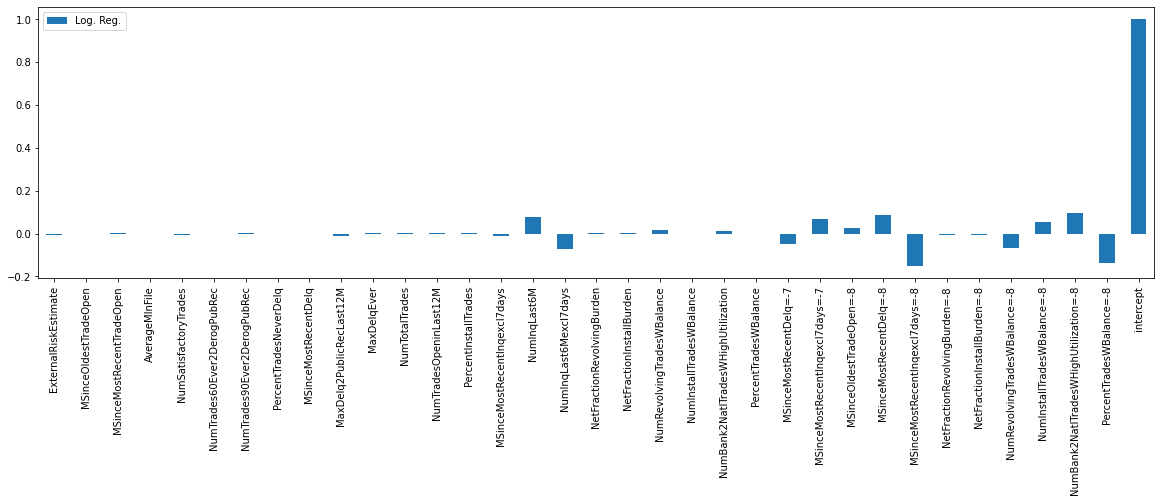

In [37]:
# plotting scaled coefficients of different features 
linear_coefficients_scaled.plot.bar(figsize=(20,5))

Some of the coefficients are consdieraby smaller than others.

Text(0.5, 1.0, 'Log. Reg.\n (1071 "Bad" predictions)')

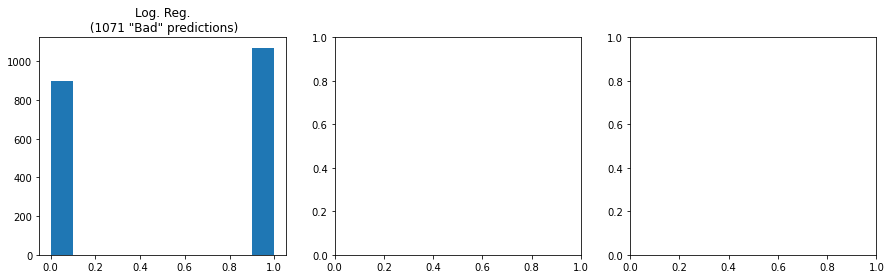

In [43]:
# analyzing "bad" preditions of logistic regression
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist(log_reg.predict(X_train_t_val))
axes[0].set_title('Log. Reg.\n (%d "Bad" predictions)'%sum(log_reg.predict(X_train_t_val)))

In [44]:
#predicting probabuilities
prob = log_reg.predict_proba(X_train_t_val)
prob0 = prob[:,0]
prob1 = prob[:,1]
prediction = log_reg.predict(X_train_t_val)
label = Y_train_t_val
correction = prediction == label

df_probs = pd.DataFrame({
    "Prob(0)": prob0,
    "Prob(1)": prob1,
    "Prediction": prediction,
    "Label": label,
    "Correct prediction": correction
})
df_probs.reset_index(drop=True, inplace=True)